In [1]:
from src_clean.dataloader.dataloader import DataLoader
from src_clean.preprocessor.prepro_new import PreprocessorTwo

In [2]:
train_df, test_df = DataLoader.load_train_test_dfs()
#train_df = PreprocessorTwo.preprocess(train_df, exclude_cols_to_drop=['srch_id', 'prop_id', 'position'])
train_df = PreprocessorTwo.remove_outliers(train_df)
train_df = PreprocessorTwo.relevance(train_df)
train_df = PreprocessorTwo.prepro_comp_columns(train_df)

#test_df = PreprocessorTwo.preprocess(test_df, exclude_cols_to_drop=['prop_id'])
test_df = PreprocessorTwo.prepro_comp_columns(test_df)
train_df, test_df = PreprocessorTwo.calculate_statistics(train_df, test_df)
train_df, test_df = PreprocessorTwo.mean_pos_per_prop_id(train_df, test_df)
#train_df, test_df = PreprocessorTwo.click_and_booking_prob(train_df, test_df)

train_df = PreprocessorTwo.extract_booking_month(train_df)
test_df = PreprocessorTwo.extract_booking_month(test_df)

train_df = PreprocessorTwo.add_price_order(train_df)
test_df = PreprocessorTwo.add_price_order(test_df)

train_df = PreprocessorTwo.drop_cols(train_df, exclude_cols_to_drop=['srch_id', 'prop_id'])
test_df = PreprocessorTwo.drop_cols(test_df)

In [3]:
X_train, X_valid, y_train, y_valid = DataLoader.split_df_into_train_and_val_batches(train_df, validation_size=0.1)

In [4]:
group_train = [group.shape[0] for group in X_train]
group_val = [group.shape[0] for group in X_valid]

## Tuning

In [7]:
import lightgbm as lgb
import numpy as np

FIXED_PARAMS={
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'early_stopping_rounds':100,
    'lambdarank_truncation_level': 5,
    'eval_at':5,
}

def train_evaluate(search_params):
    params = {'metric':FIXED_PARAMS['metric'],
              'objective':FIXED_PARAMS['objective'],
              'early_stopping_rounds':50,
              'num_iterations': 500,
              'eval_at':5,
              **search_params}

    train_data = lgb.Dataset(np.vstack(X_train), label=np.hstack(y_train), group=group_train)
    valid_data = lgb.Dataset(np.vstack(X_valid), label=np.hstack(y_valid), reference=train_data, group=group_val)

    model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=[valid_data],
        early_stopping_rounds=FIXED_PARAMS['early_stopping_rounds'],
        valid_names=['valid'],
    )

    best_score = model.best_score['valid']['ndcg@5']
    return best_score

In [9]:
  import skopt
SPACE = [
    skopt.space.Real(0.01, 0.2, name='learning_rate', prior='log-uniform'),
    skopt.space.Integer(5, 400, name='max_depth'),
    skopt.space.Integer(10, 400, name='num_leaves'),
    skopt.space.Integer(200, 10000, name='min_data_in_leaf'),

]

@skopt.utils.use_named_args(SPACE)
def objective(**params):
    return -1.0 * train_evaluate(params)

results = skopt.gp_minimize(objective, SPACE, n_calls=100, n_random_starts=10)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.785751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36817
[LightGBM] [Info] Number of data points in the train set: 4459619, number of used features: 208
[1]	valid's ndcg@5: 0.325994
Training until validation scores don't improve for 50 rounds
[2]	valid's ndcg@5: 0.347673
[3]	valid's ndcg@5: 0.360479
[4]	valid's ndcg@5: 0.366169
[5]	valid's ndcg@5: 0.370332
[6]	valid's ndcg@5: 0.373647
[7]	valid's ndcg@5: 0.376071
[8]	valid's ndcg@5: 0.377753
[9]	valid's ndcg@5: 0.379802
[10]	valid's ndcg@5: 0.380473
[11]	valid's ndcg@5: 0.381698
[12]	valid's ndcg@5: 0.383072
[13]	valid's ndcg@5: 0.384221
[14]	valid's ndcg@5: 0.384247
[15]	valid's ndcg@5: 0.385703
[16]	valid's ndcg@5: 0.386511
[17]	valid's ndcg@5: 0.387567
[18]	valid's ndcg@5: 0.387307
[19]	valid's ndcg@5: 0.38808
[20]	valid's ndcg@5

In [13]:
results.fun

-0.41983660569831754

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

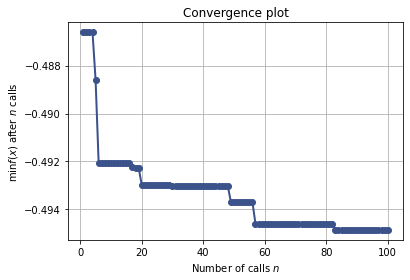

In [27]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(results)

In [11]:
def to_named_params(results, search_space):
    params = results.x
    param_dict = {}
    params_list  =[(dimension.name, param) for dimension, param in zip(search_space, params)]
    for item in params_list:
        param_dict[item[0]] = item[1]

    return(param_dict)

In [12]:
best_params = to_named_params(results, SPACE)
best_params

{'learning_rate': 0.047311784907414445,
 'max_depth': 400,
 'num_leaves': 272,
 'min_data_in_leaf': 9433}

In [15]:
best_params = {'learning_rate': 0.05845913487454412,
               'max_depth': 26,
               'num_leaves': 200,
               'feature_fraction': 0.6070425668062532,
               'subsample': 0.33076642445893534,
               'bagging_freq': 0,
               'bagging_fraction': 1.0,
               'lambda_l1': 0.08208960574318575,
               'lambda_l2': 0.6563109288436756,
               'num_iterations': 300}

In [12]:
model = lgb.LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    **best_params
)

In [13]:
model.fit(
    X=np.vstack(X_train),
    y=np.hstack(y_train),
    group=group_train,
    eval_set=[(np.vstack(X_valid), np.hstack(y_valid))],
    eval_group=[group_val],
    eval_at=5,
    verbose=10
)

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0.9833204319518789, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9833204319518789
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.23257135310040863 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.8899858994511017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8899858994511017
[10]	valid_0's ndcg@5: 0.376862
[20]	valid_0's ndcg@5: 0.384925
[30]	valid_0's ndcg@5: 0.389166
[40]	valid_0's ndcg@5: 0.390834
[50]	valid_0's ndcg@5: 0.392744
[60]	valid_0's ndcg@5: 0.394096
[70]	valid_0's ndcg@5: 0.39509
[80]	valid_0's ndcg@5: 0.396414
[90]	valid_0's ndcg@5: 0.396563
[100]	valid_0's ndcg@5: 0.397299
[110]	valid_0's ndcg@5: 0.397302
[120]	valid_0's

LGBMRanker(bagging_fraction=1.0, bagging_freq=8, feature_fraction=1.0,
           lambda_l1=0.8899858994511017, lambda_l2=0.9833204319518789,
           learning_rate=0.08830795771140433, max_depth=10, metric='ndcg',
           num_iterations=350, num_leaves=158, objective='lambdarank',
           subsample=0.23257135310040863)

In [14]:
pred = model.predict(test_df.to_numpy())
ranker = Ranker()
ranking_file_path = ranker.make_ranking_from_prediction(
    pred, model_name="LightGBM"
)
calculate_ndcg(ranking_file_path)

0.40422968757373423

In [27]:
test_df

,visitor_hist_starrating,visitor_hist_adr_usd,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,...,srch_saturday_night_bool_median,prop_brand_bool_median,srch_length_of_stay_median,srch_booking_window_median,prop_location_score1_median,srch_query_affinity_score_median,promotion_flag_median,prop_location_score2_median,srch_adults_count_median,random_bool_median
0,0.0,0.0,3,4.5,1,2.94,0.0691,5.03,119.00,0,...,1.0,1.0,1.0,8.0,2.94,-13.2785,0.0,0.0251,2.0,0.0
1,0.0,0.0,3,4.5,1,2.94,0.0077,0.00,129.00,0,...,1.0,1.0,1.0,8.0,2.94,-13.2785,0.0,0.0251,2.0,0.0
2,0.0,0.0,3,4.5,1,2.94,0.0077,5.02,141.47,0,...,1.0,1.0,1.0,8.0,2.94,-13.2785,0.0,0.0251,2.0,0.0
3,0.0,0.0,3,4.5,1,2.94,0.0077,5.02,107.00,1,...,1.0,1.0,1.0,8.0,2.94,-13.2785,0.0,0.0251,2.0,0.0
4,0.0,0.0,3,4.5,1,2.94,0.0691,5.01,119.00,0,...,1.0,1.0,1.0,8.0,2.94,-13.2785,0.0,0.0251,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4959178,0.0,0.0,0,0.0,0,4.09,0.0000,4.73,99.32,0,...,1.0,0.0,3.0,98.0,4.09,-1.0000,0.0,0.0000,2.0,1.0
4959179,0.0,0.0,0,0.0,0,0.00,0.0000,4.64,77.10,0,...,1.0,0.0,2.0,23.0,0.00,-1.0000,0.0,0.0000,2.0,0.0
4959180,0.0,0.0,3,0.0,0,3.53,0.0000,0.00,55.95,0,...,0.0,0.0,13.0,39.0,3.53,-1.0000,0.0,0.0000,2.0,1.0
4959181,0.0,0.0,2,0.0,0,3.69,0.0000,0.00,49.45,0,...,0.0,0.0,13.0,39.0,3.69,-1.0000,0.0,0.0000,2.0,1.0


In [9]:
|train_df

,srch_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,position,...,srch_saturday_night_bool,orig_destination_distance,random_bool,comp_cheaper,season,mean_price,prop_price_diff,fee_person,total_fee,relevance
0,1,187,219,893,3,3.5,1,2.83,0.043800,27,...,1,NaN,1,0,0,118.758742,36.404964,26.192500,104.77,0
1,1,187,219,10404,4,4.0,1,2.20,0.014900,26,...,1,NaN,1,0,0,152.054082,-17.806987,42.685000,170.74,0
2,1,187,219,21315,3,4.5,1,2.20,0.024500,21,...,1,NaN,1,0,0,168.540871,-42.797387,44.950000,179.80,0
3,1,187,219,27348,2,4.0,1,2.83,0.012500,34,...,1,NaN,1,-1,0,82.598870,-522.129581,150.692500,602.77,0
4,1,187,219,29604,4,3.5,1,2.64,0.124100,4,...,1,NaN,1,0,0,137.648135,-5.200488,35.895000,143.58,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958342,332785,219,219,77700,3,4.0,1,1.61,0.047100,2,...,0,550.92,0,0,1,131.241702,-117.000000,39.333333,118.00,0
4958343,332785,219,219,88083,3,4.0,1,1.95,0.152000,3,...,0,553.14,0,0,1,84.545789,-88.000000,29.666667,89.00,0
4958344,332785,219,219,94508,3,3.5,1,1.10,0.016400,4,...,0,544.43,0,0,1,116.537209,-98.000000,33.000000,99.00,0
4958345,332785,219,219,128360,3,5.0,1,1.95,0.066200,1,...,0,550.38,0,0,1,150.336757,-138.000000,46.333333,139.00,5
